In [1]:
!pip install -r requirements.txt --quiet
#!mkdir -p /content/data

In [55]:
import moviepy
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import os
import pickle
import soundfile as sf

from IPython.display import Video
from IPython.display import Audio
from moviepy.editor import VideoFileClip
from keras.models import Model
from keras.layers import Dense, LSTM, RepeatVector, Input, TimeDistributed
from keras import layers
from keras.utils import plot_model
from tensorflow import keras


#from google.colab import drive
#drive.mount('/content/drive')

### Displaying sample video with speech of same person in two different langauges English and spanish

In [3]:
# base_path = '/content/drive/MyDrive/AI_ML/Tech Challenges/Language Machines'
base_path = 'data'
sample_video_english_path = f'{base_path}/sample_english.mp4'
sample_video_spanish_path = f'{base_path}/sample_spanish.mp4'

In [4]:
# moviepy.editor.ipython_display(sample_video_english_path)

In [5]:
# moviepy.editor.ipython_display(sample_video_spanish_path)

### Extracting audio signal from video file

In [6]:
def create_file_path(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


def extract_audio(video_path, output_audio_path):
    try:
        video = VideoFileClip(video_path)
        audio = video.audio
        create_file_path(output_audio_path)
        audio.write_audiofile(output_audio_path)
        audio.close()
        video.close()
        print("Audio extraction successful.")
    except Exception as e:
        print(f"Error: {e}")


src_audio_folder = f'{base_path}/src_audio'
target_audio_folder = f'{base_path}/target_audio'
sample_audio_english_path = f'{src_audio_folder}/sample_english_audio.mp3'
sample_audio_spanish_path = f'{target_audio_folder}/sample_spanish_audio.mp3'
extract_audio(sample_video_english_path, sample_audio_english_path)
extract_audio(sample_video_spanish_path, sample_audio_spanish_path)

MoviePy - Writing audio in data/src_audio/sample_english_audio.mp3


MoviePy - Done.
Audio extraction successful.
MoviePy - Writing audio in data/target_audio/sample_spanish_audio.mp3


MoviePy - Done.
Audio extraction successful.


### Spectrogram for audio signals

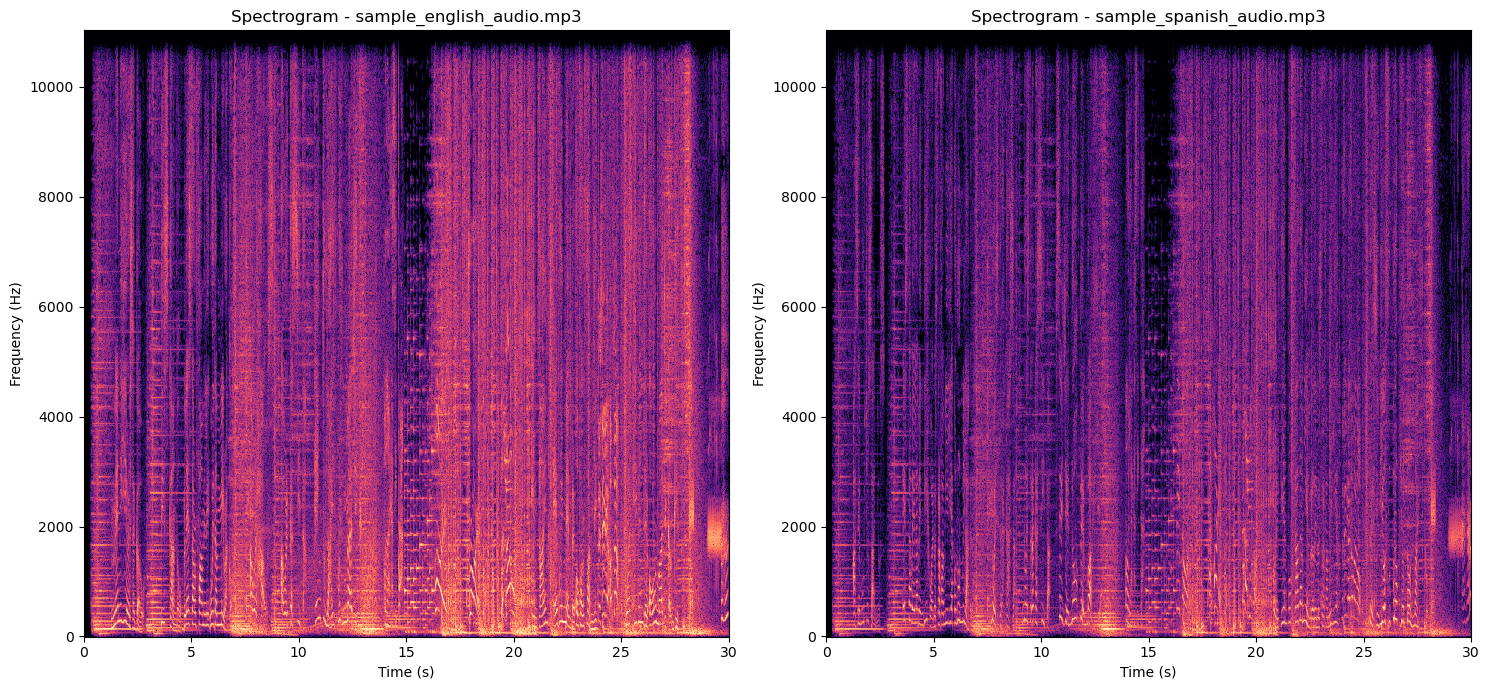

In [7]:
def plot_spectrogram(audio_path, ax):
    y, sr = librosa.load(audio_path)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', ax=ax)
    ax.set_title(f"Spectrogram - {audio_path.split('/')[-1]}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")


fig, axes = plt.subplots(1, 2, figsize=(15, 7))
plot_spectrogram(sample_audio_english_path, axes[0])
plot_spectrogram(sample_audio_spanish_path, axes[1])
plt.tight_layout()
plt.show()

### Feature data preparation

In [21]:
sample_rate = 20000


def extract_audio_vector(audio_folder):
    audio_data = []
    for filename in os.listdir(audio_folder):
        file_path = os.path.join(audio_folder, filename)
        if file_path.endswith("mp3"):
            audio, _ = librosa.load(file_path, sr=sample_rate)
            audio_data.append(audio)
    return np.array(audio_data)


src_audio_data = extract_audio_vector(src_audio_folder)
target_audio_data = extract_audio_vector(target_audio_folder)

print("Source audio vector shape", src_audio_data.shape)
print("Target audio vector shape", target_audio_data.shape)

Source audio vector shape (1, 600200)
Target audio vector shape (1, 600200)


In [23]:
def extract_mfcc_features(audio_data):
    mfcc_features = []
    for audio in audio_data:
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate)
        mfcc_features.append(mfcc)
    return np.array(mfcc_features)


src_audio_mfcc = extract_mfcc_features(src_audio_data)
target_audio_mfcc = extract_mfcc_features(target_audio_data)

print("Source audio features shape", src_audio_mfcc.shape)
print("Target audio features shape", target_audio_mfcc.shape)

Source audio features shape (1, 20, 1173)
Target audio features shape (1, 20, 1173)


### Save the data to a pickle file for model training

In [24]:
def save_to_pickle(feature_data, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(feature_data, f)


src_audio_pickle_file_path = f'{src_audio_folder}/sample_english_audio.pkl'
target_audio_pickle_file_path = f'{target_audio_folder}/sample_spanish_audio.pkl'

save_to_pickle(src_audio_mfcc, src_audio_pickle_file_path)
save_to_pickle(target_audio_mfcc, target_audio_pickle_file_path)

## Model Development

In [25]:
def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)


train_data = load_pickle_file(src_audio_pickle_file_path)
target_data = load_pickle_file(target_audio_pickle_file_path)

print("Train data shape", train_data.shape)
print("Target data shape", target_data.shape)

Train data shape (1, 20, 1173)
Target data shape (1, 20, 1173)


### Hyperparameters

In [29]:
timesteps = train_data.shape[1]
features = train_data.shape[2]
latent_dim = 64
dropout_rate = 0.1
activation = 'relu'
optimizer = 'adam'
loss = 'mean_squared_error'

### Model Architecure

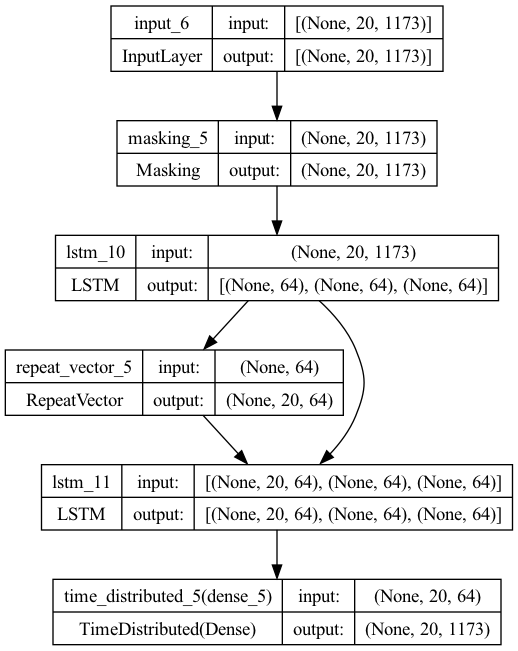

In [30]:
inputs = Input(shape=(timesteps, features))

#Encoder
masked_encoder_inputs = layers.Masking()(inputs)
encoder_lstm = (LSTM(latent_dim, return_state=True))
encoder_outputs, state_h, state_c = encoder_lstm(masked_encoder_inputs)
encoder_states = [state_h, state_c]

#Decoder
decoder_inputs = RepeatVector(timesteps)(encoder_outputs)
decoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_outputs = TimeDistributed(Dense(features, activation=activation))(decoder_outputs)

model = Model(inputs, decoder_outputs)
encoder = Model(inputs, encoder_outputs)

model.compile(optimizer=optimizer, loss=loss)
plot_model(model, to_file='model_flowchart.png', show_shapes=True, show_layer_names=True)

### Model Training

In [31]:
batch_size = 64
epochs = 100
validation_split = 0

model.fit(train_data, target_data, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 2182.0745
Epoch 2/1000
1/1 [==============================] - 0s 18ms/step - loss: 2182.0930
Epoch 3/1000
1/1 [==============================] - 0s 20ms/step - loss: 2181.9795
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step - loss: 2181.8884
Epoch 5/1000
1/1 [==============================] - 0s 18ms/step - loss: 2181.8279
Epoch 6/1000
1/1 [==============================] - 0s 16ms/step - loss: 2181.7556
Epoch 7/1000
1/1 [==============================] - 0s 17ms/step - loss: 2181.6880
Epoch 8/1000
1/1 [==============================] - 0s 17ms/step - loss: 2181.6184
Epoch 9/1000
1/1 [==============================] - 0s 18ms/step - loss: 2181.5544
Epoch 10/1000
1/1 [==============================] - 0s 16ms/step - loss: 2181.4883
Epoch 11/1000
1/1 [==============================] - 0s 18ms/step - loss: 2181.4106
Epoch 12/1000
1/1 [==============================] - 0s 16ms/step - loss: 2181.3359
Epo

In [37]:
# Save the model
version = 1.0
model_name = f'lstm-encoder-decoder-{version}.h5'
model.save(f'lstm-encoder-decoder-{version}.h5')

## Inference Pipeline

In [38]:
# Load the saved model
model = keras.models.load_model(model_name)

In [58]:
def inverse_mfcc(mfccs, n_mels, hop_length):
    audio_data = librosa.feature.inverse.mfcc_to_audio(mfccs, sr= sample_rate)
    return audio_data

predicted_target = model.predict(train_data)
predicted_audio_list = []

for predicted_mfcc in predicted_target:
    predicted_audio = inverse_mfcc(predicted_mfcc, features, timesteps)
    predicted_audio_list.append(predicted_audio)

predicted_audio_array = np.concatenate(predicted_audio_list, axis=0)

#
predicted_audio_path = f"{base_path}/predicted_spanish_audio.wav"
sf.write(predicted_audio_path, predicted_audio_array, sample_rate, 'PCM_24')


1/1 [==============================] - 0s 22ms/step


In [59]:
from moviepy.editor import VideoFileClip, AudioFileClip

def append_audio_to_video(video_path, audio_path, output_path):
    # Load the video and audio clips
    video_clip = VideoFileClip(video_path)
    audio_clip = AudioFileClip(audio_path)

    # Set the audio of the video clip to be the loaded audio clip
    video_clip = video_clip.set_audio(audio_clip)

    # Save the resulting video with the appended audio
    video_clip.write_videofile(output_path, codec="libx264", audio_codec="aac")

    # Close the video and audio clips
    video_clip.reader.close()
    video_clip.audio.reader.close_proc()
    audio_clip.reader.close_proc()


output_video_file = f"{base_path}/sample_predicted_spanish.mp4"
append_audio_to_video(sample_video_english_path, predicted_audio_path, output_video_file)

Moviepy - Building video data/sample_predicted_spanish.mp4.
MoviePy - Writing audio in sample_predicted_spanishTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video data/sample_predicted_spanish.mp4



Moviepy - Done !
Moviepy - video ready data/sample_predicted_spanish.mp4


In [ ]:
moviepy.editor.ipython_display(output_video_file)